<a href="https://colab.research.google.com/github/paul2803/locked-in-syndrome/blob/main/Sep4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from torch.nn.modules import Dropout
import torch
from torch import nn, optim, tensor
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from torch.utils.tensorboard import SummaryWriter
import math
import copy


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters

In [ ]:
#Parameters

#better to use smaller numbers first, then switch to higher for lower computation time

#batch_size = 8
batch_size = 30
learning_rate = 0.001
#learning_rate = 0.005
#num_epochs = 10
num_epochs = 25
num_classes = 2
num_channels = 3

# Load and prepare data

In [ ]:
#Alexnet takes images of size at lest 224 pixels of Width and height --> resize all data into 224x224
data_transform = {
    'TRAIN': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'VAL': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'TEST': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

#imagedatasets
train_data = ImageFolder("/content/drive/MyDrive/archive/train", transform = data_transform['VAL'])
train, val = random_split(train_data, [0.7, 0.3])
test_data = ImageFolder("/content/drive/MyDrive/archive/test", transform = data_transform['TEST'])

#dataloaders
train_loader = DataLoader(train, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=True)

print(f"Loaded {len(train)} images under train")
print(f"Loaded {len(val)} images under val")
print(f"Loaded {len(test_data)} images under test")
print("Follwing classes are there : \n", train_data.classes)

Loaded 1846 images under train
Loaded 791 images under val
Loaded 660 images under test
Follwing classes are there : 
 ['benign', 'malignant']


Label : benign


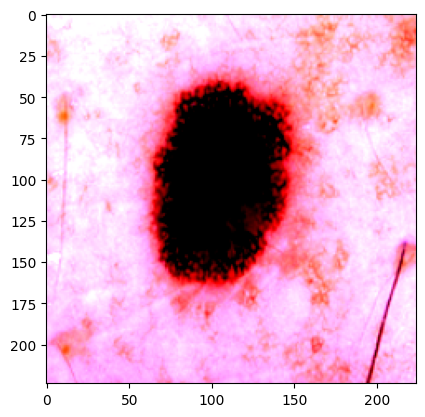

In [ ]:
img, label = train_data[0]
print(f"Label : {train_data.classes[label]}")
plt.imshow(img.permute(1,2,0))

# Define a CNN model

In [ ]:
#added .to(device)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='DEFAULT').to(device)
model.eval()
params = model.parameters()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 245MB/s]


In [ ]:
#added .to(device)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='DEFAULT').to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
optimizer_ft = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
loss = nn.CrossEntropyLoss()

# V2 - old methhode - training network of AlexNet shape from scratch

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            #HERE I had to change the parameter from 9216 to 6400
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = AlexNet(num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


In [ ]:
total_step = len(train_loader)

In [ ]:

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(791, 100 * correct / total))

Epoch [1/25], Step [62/62], Loss: 0.1128
Accuracy of the network on the 791 validation images: 95.19595448798988 %
Epoch [2/25], Step [62/62], Loss: 0.0929
Accuracy of the network on the 791 validation images: 95.95448798988622 %
Epoch [3/25], Step [62/62], Loss: 0.0129
Accuracy of the network on the 791 validation images: 95.448798988622 %
Epoch [4/25], Step [62/62], Loss: 0.0762
Accuracy of the network on the 791 validation images: 95.70164348925411 %
Epoch [5/25], Step [62/62], Loss: 0.1091
Accuracy of the network on the 791 validation images: 94.18457648546143 %
Epoch [6/25], Step [62/62], Loss: 0.0425
Accuracy of the network on the 791 validation images: 94.94310998735777 %
Epoch [7/25], Step [62/62], Loss: 0.0198
Accuracy of the network on the 791 validation images: 95.32237673830595 %
Epoch [8/25], Step [62/62], Loss: 0.0027
Accuracy of the network on the 791 validation images: 95.19595448798988 %
Epoch [9/25], Step [62/62], Loss: 0.0017
Accuracy of the network on the 791 valida

In [ ]:
#Testing
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(660, 100 * correct / total))

Accuracy of the network on the 660 test images: 88.48484848484848 %


# V3 - same as above, just without .to(device)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            #HERE I had to change the parameter from 9216 to 6400
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = AlexNet(num_classes)
params= model.parameters()

In [ ]:
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


In [ ]:
#ALTERNATIVELLY
#Define an optimiser
optimiser = optim.Adam(params, lr=learning_rate)

#Define loss function
loss = nn.CrossEntropyLoss()

In [ ]:
total_step = len(train_loader)

In [ ]:
for epoch in range(num_epochs):

  #Training loops
  losses = list()
  for batch in train_loader:
    x,y = batch
    #Forward propagation
    pred_outputs = model(x)

    #loss = criterion(pred_outputs, labels)

    #ALTERNATIVELLY
    l = loss(pred_outputs, y)

    #Backward propagation
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    losses.append(l.item())

  print(f'Epoch {epoch + 1}/{num_epochs}, train loss: {torch.tensor(losses).mean():.3f}')

  #Validation Loss
  losses = list()
  accuracies = list()

  for batch in val_loader:
    x,y = batch
    #Forward propagation
    with torch.no_grad():
      pred_outputs = model(x)
    #Calculate loss
    l = loss (pred_outputs, y)
    #Calculate accuracy
    _, preds = torch.max(pred_outputs, dim=1)
    acc = torch.tensor(torch.sum(preds == y).item() / len(preds))

    losses.append(l.item())
    accuracies.append(acc.item())

  print(f'Epoch {epoch + 1}/{num_epochs}, validation loss: {torch.tensor(losses).mean():.3f}, accuracy: {torch.tensor(accuracies).mean():.3f}')

Epoch 1/10, train loss: 0.717
Epoch 1/10, validation loss: 0.708, accuracy: 0.472
Epoch 2/10, train loss: 0.719
Epoch 2/10, validation loss: 0.706, accuracy: 0.479
Epoch 3/10, train loss: 0.719
Epoch 3/10, validation loss: 0.713, accuracy: 0.462
Epoch 4/10, train loss: 0.711
Epoch 4/10, validation loss: 0.698, accuracy: 0.495
Epoch 5/10, train loss: 0.715
Epoch 5/10, validation loss: 0.698, accuracy: 0.480
Epoch 6/10, train loss: 0.716
Epoch 6/10, validation loss: 0.708, accuracy: 0.477
Epoch 7/10, train loss: 0.719
Epoch 7/10, validation loss: 0.705, accuracy: 0.479
Epoch 8/10, train loss: 0.715
Epoch 8/10, validation loss: 0.705, accuracy: 0.492
Epoch 9/10, train loss: 0.716
Epoch 9/10, validation loss: 0.706, accuracy: 0.475
Epoch 10/10, train loss: 0.712
Epoch 10/10, validation loss: 0.705, accuracy: 0.477


# Train the old model

Train the old model (I don't use ths part)

In [ ]:
for epoch in range(num_epochs):

  #Training loops
  losses = list()
  for batch in train_loader:
    x,y = batch
    #Forward propagation
    pred_outputs = model(x)
    l = loss(pred_outputs, y)
    #Backward propagation
    optimiser.zero_grad()
    l.backward()
    optimiser.step()

    losses.append(l.item())

  print(f'Epoch {epoch + 1}/{num_epochs}, train loss: {torch.tensor(losses).mean():.3f}')

  #Validation Loss
  losses = list()
  accuracies = list()

  for batch in val_loader:
    x,y = batch
    #Forward propagation
    with torch.no_grad():
      pred_outputs = model(x)
    #Calculate loss
    l = loss (pred_outputs, y)
    #Calculate accuracy
    _, preds = torch.max(pred_outputs, dim=1)
    acc = torch.tensor(torch.sum(preds == y).item() / len(preds))

    losses.append(l.item())
    accuracies.append(acc.item())

  #Add loss to Tensorboard
  writer.add_scalar("Loss/train", torch.tensor(losses).mean(), epoch)

  #Print losses and accuracy
  print(f'Epoch {epoch + 1}/{num_epochs}, validation loss: {torch.tensor(losses).mean():.3f}, accuracy: {torch.tensor(accuracies).mean():.3f}')

writer.flush()

KeyboardInterrupt: ignored

# Editing the last layer

In [ ]:
#Idk why but I cen't get rid of it I tried just loading ready, already changed NN with parameters, but for the frst run it doesn't work properly
#I have to do this step (loading original AlexNet, replacing the last layer) for the first run

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_weights.pth')
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/model_weights.pth"))
#print(model.classifier[6].out_features)


for param in model.features.parameters():
    param.require_grad = False

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 2 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

#print(model)

if use_gpu:
    model.cuda() #.cuda() will move everything to the GPU side

# Train

In [ ]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc_val = 0
escape = 0
#Plot data
plot_train_losses = []
plot_val_losses = []
plot_train_accuracies = []
plot_val_accuracies = []

model.to(device)
for epoch in range(num_epochs):
    losses = list()
    accuracies = list()
    model.train(True)

    for data in train_loader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #Forward propagation
        outputs = model(inputs)
        #Calculate loss
        l = loss(outputs, labels)
        #Backward propagation
        optimizer_ft.zero_grad()
        l.backward()
        optimizer_ft.step()
        #Calculate accuracy
        _, preds = torch.max(outputs, dim=1)
        acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))

        losses.append(l.item())
        accuracies.append(acc.item())

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    print(f'Epoch {epoch + 1}/{num_epochs}, train loss: {torch.tensor(losses).mean():.3f}, accuracy: {torch.tensor(accuracies).mean():.3f}')

    #Append losses and accuracies for plotting data
    plot_train_losses.append(torch.tensor(losses).mean())
    plot_train_accuracies.append(torch.tensor(accuracies).mean())

    model.train(False)
    model.eval()
    #Validation Loss
    losses = list()
    accuracies = list()

    for data in val_loader:
        inputs, labels = data
        if use_gpu:
          inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
          inputs, labels = Variable(inputs), Variable(labels)
        #Forward propagation
        with torch.no_grad():
          outputs = model(inputs)
        #Calculate loss
        l = loss(outputs, labels)
        #Calculate accuracy
        _, preds = torch.max(outputs, dim=1)
        acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))

        losses.append(l.item())
        accuracies.append(acc.item())

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    #Print losses and accuracy
    print(f'Epoch {epoch + 1}/{num_epochs}, validation loss: {torch.tensor(losses).mean():.3f}, accuracy: {torch.tensor(accuracies).mean():.3f}')

    #Append losses and accuracies for plotting data
    plot_val_losses.append(torch.tensor(losses).mean())
    plot_val_accuracies.append(torch.tensor(accuracies).mean())

    #Early Stopping
    tmp_accuracies = torch.tensor(accuracies).mean()
    if best_acc_val < tmp_accuracies:
        best_acc_val = tmp_accuracies
        best_model_wts = copy.deepcopy(model.state_dict())
        model.load_state_dict(best_model_wts)
        escape = 0
    escape += 1
    if escape == 5:
      break


torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_weights.pth')

Epoch 1/25, train loss: 0.254, accuracy: 0.895
Epoch 1/25, validation loss: 0.090, accuracy: 0.978
Epoch 2/25, train loss: 0.085, accuracy: 0.976
Epoch 2/25, validation loss: 0.073, accuracy: 0.972
Epoch 3/25, train loss: 0.069, accuracy: 0.978
Epoch 3/25, validation loss: 0.064, accuracy: 0.974
Epoch 4/25, train loss: 0.050, accuracy: 0.987
Epoch 4/25, validation loss: 0.063, accuracy: 0.977
Epoch 5/25, train loss: 0.043, accuracy: 0.986
Epoch 5/25, validation loss: 0.076, accuracy: 0.972
